In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

### Loading Dataset

In [46]:
train = pd.read_csv("/home/hasan/Data Set/Kannada-MNIST/train.csv")
test = pd.read_csv("/home/hasan/Data Set/Kannada-MNIST/test.csv")
dig_mnist = pd.read_csv("/home/hasan/Data Set/Kannada-MNIST/Dig-MNIST.csv")
sample_submission = pd.read_csv("/home/hasan/Data Set/Kannada-MNIST/sample_submission.csv")

In [47]:
print(f"Shape of train is {train.shape} \nShape of test is {test.shape} \nShape of dig_mnist is {dig_mnist.shape} \nShape of sample_submission is {sample_submission.shape}")

Shape of train is (60000, 785) 
Shape of test is (5000, 785) 
Shape of dig_mnist is (10240, 785) 
Shape of sample_submission is (5000, 2)


In [48]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
train.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [50]:
test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
dig_mnist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
sample_submission.head()

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5


### Feature and Label dataset

In [53]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values
print(f"Shape of X is {X.shape} Shape of y is {y.shape}")

Shape of X is (60000, 784) Shape of y is (60000,)


In [54]:
X = X.reshape(X.shape[0], 28,28, 1)
X.shape


(60000, 28, 28, 1)

### One Hot Encoding

In [55]:
y = to_categorical(y, 10)
y.shape

(60000, 10)

### Dividing Dataset

In [56]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size = 0.10, random_state=42)

### ImageDataGenerator

In [57]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.1,
                                   zoom_range = 0.25,
                                   horizontal_flip = False)

In [58]:
valid_datagen = ImageDataGenerator(rescale=1./255)

### Build Model

In [59]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),    
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)       

In [60]:
initial_learningrate=2e-3
batch_size = 1024
epochs = 30
input_shape = (28, 28, 1)

In [61]:
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=initial_learningrate),
              metrics=['accuracy'])


In [62]:
def lr_decay(epoch):#lrv
    return initial_learningrate * 0.99 ** epoch

In [63]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

### Model Training

In [64]:
history = model.fit(
      train_datagen.flow(X_train,Y_train, batch_size=batch_size),
      steps_per_epoch=100,
      epochs=epochs,
      callbacks=[LearningRateScheduler(lr_decay),
                 es],
      validation_data=valid_datagen.flow(X_valid,Y_valid),
      validation_steps=50,  
      verbose=2)

Epoch 1/30
100/100 - 42s - loss: 0.5326 - acc: 0.8238 - val_loss: 0.9378 - val_acc: 0.9475
Epoch 2/30
100/100 - 39s - loss: 0.0930 - acc: 0.9697 - val_loss: 0.2725 - val_acc: 0.9269
Epoch 3/30
100/100 - 38s - loss: 0.0615 - acc: 0.9798 - val_loss: 0.0369 - val_acc: 0.9900
Epoch 4/30
100/100 - 39s - loss: 0.0524 - acc: 0.9833 - val_loss: 0.0825 - val_acc: 0.9781
Epoch 5/30
100/100 - 38s - loss: 0.0430 - acc: 0.9862 - val_loss: 0.0309 - val_acc: 0.9912
Epoch 6/30
100/100 - 38s - loss: 0.0409 - acc: 0.9863 - val_loss: 0.0098 - val_acc: 0.9975
Epoch 7/30
100/100 - 38s - loss: 0.0371 - acc: 0.9877 - val_loss: 0.0070 - val_acc: 0.9975
Epoch 8/30
100/100 - 39s - loss: 0.0335 - acc: 0.9895 - val_loss: 0.0646 - val_acc: 0.9787
Epoch 9/30
100/100 - 38s - loss: 0.0317 - acc: 0.9895 - val_loss: 0.0118 - val_acc: 0.9956
Epoch 10/30
100/100 - 39s - loss: 0.0314 - acc: 0.9900 - val_loss: 0.0107 - val_acc: 0.9975
Epoch 11/30
100/100 - 38s - loss: 0.0297 - acc: 0.9900 - val_loss: 0.0084 - val_acc: 0.99

### Accuracy and Loss Graph

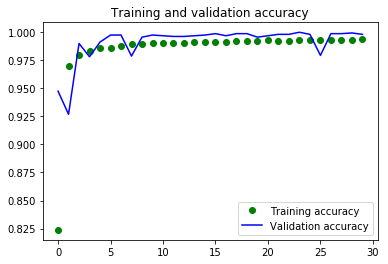

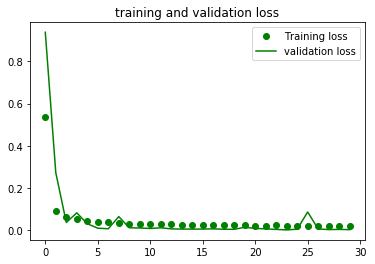

In [67]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

### Model Save 

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("cannad_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize weights to HDF5
model.save_weights("cannada_model.h5")


### Featuren and Label of dig_mnist

In [68]:
x_dig = dig_mnist.drop('label', axis=1).iloc[:,:].values
x_dig = x_dig.reshape(x_dig.shape[0], 28,28,1)
x_dig.shape

(10240, 28, 28, 1)

In [69]:
y_dig = dig_mnist.label
y_dig.shape

(10240,)

### Prediction

In [70]:
preds_dig=np.argmax(model.predict(x_dig/255), axis=-1)
metrics.accuracy_score(preds_dig, y_dig)

0.9099609375

### Confusion Matrix

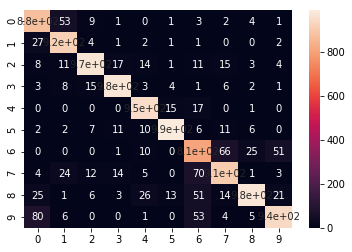

In [71]:
#with annot parameter
cf_matrix = sns.heatmap(confusion_matrix(preds_dig, y_dig), annot=True)

### Training with All Dataset

In [72]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),    
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [73]:
initial_learningrate=2e-3
batch_size = 1024
epochs = 30
input_shape = (28, 28, 1)

In [74]:
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=initial_learningrate),
              metrics=['accuracy'])

In [75]:
history = model.fit_generator(
      train_datagen.flow(X,Y, batch_size=batch_size),
      steps_per_epoch=100,
      epochs=epochs,
      callbacks=[LearningRateScheduler(lr_decay)           
               ],
      validation_data=valid_datagen.flow(X_valid,Y_valid),
      validation_steps=50,  
      verbose=2)

Epoch 1/30
100/100 - 46s - loss: 0.5154 - acc: 0.8307 - val_loss: 0.8908 - val_acc: 0.9162
Epoch 2/30
100/100 - 40s - loss: 0.0895 - acc: 0.9706 - val_loss: 0.1738 - val_acc: 0.9944
Epoch 3/30
100/100 - 42s - loss: 0.0603 - acc: 0.9802 - val_loss: 0.0243 - val_acc: 0.9969
Epoch 4/30
100/100 - 42s - loss: 0.0518 - acc: 0.9829 - val_loss: 0.0118 - val_acc: 0.9969
Epoch 5/30
100/100 - 43s - loss: 0.0451 - acc: 0.9852 - val_loss: 0.0151 - val_acc: 0.9931
Epoch 6/30
100/100 - 41s - loss: 0.0404 - acc: 0.9867 - val_loss: 0.0840 - val_acc: 0.9812
Epoch 7/30
100/100 - 42s - loss: 0.0376 - acc: 0.9873 - val_loss: 0.0063 - val_acc: 0.9981
Epoch 8/30
100/100 - 43s - loss: 0.0348 - acc: 0.9886 - val_loss: 0.0541 - val_acc: 0.9825
Epoch 9/30
100/100 - 41s - loss: 0.0332 - acc: 0.9893 - val_loss: 0.0039 - val_acc: 0.9987
Epoch 10/30
100/100 - 42s - loss: 0.0312 - acc: 0.9899 - val_loss: 0.0048 - val_acc: 0.9994
Epoch 11/30
100/100 - 42s - loss: 0.0297 - acc: 0.9901 - val_loss: 0.0381 - val_acc: 0.98

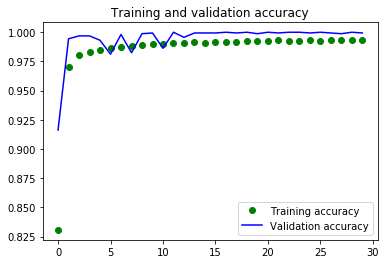

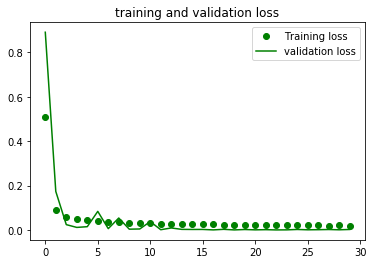

In [76]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [78]:
preds_dig=model.predict_classes(x_dig/255)
metrics.accuracy_score(preds_dig, y_dig)

0.910546875

In [79]:
x_test = test.drop('id', axis=1).iloc[:,:].values
x_test = x_test.reshape(x_test.shape[0], 28,28,1)
x_test.shape

(5000, 28, 28, 1)

In [80]:
predictions = model.predict_classes(x_test/255.)

### Submission File

In [81]:
sample_submission['label'] = predictions

In [ ]:
sample_submission.head()